Sentiment Dataset:
                                                text  label
0    ज्येष्ठ पत्रकार अनंत दीक्षित यांच्या निधनाचे...     -1
1    सर्वोच्च न्यायालयाचे निर्देश डावलून पुणे पोल...     -1
2    उद्धव ठाकरेंनी भाजपासोबत युती करून शिवसैनिका...     -1
3    आपला समाज खूप मोठा आहे. त्यात अनेक घटक अंतर्...      1
4  बलात्काराचा बदला बलात्काराने घेतला पाहिजे हे म...     -1

Hate Speech Dataset:
                                                text label
0  @lokmat बहुसंख्यांक हिंदूंना घाबरट आणि मुर्ख ब...  HATE
1  @BalaNandgaonkar स्वतःचे खिसे भरत आहेत, यांना ...  HATE
2  या पुचाट UNO पेक्षा आमच्याकडचं ENO जास्त प्रभा...  HATE
3  एक हिजाब परिधान केलेली मुलगी काल परवापासून व्ह...  HATE
4  @KiritSomaiya @BJP4India @BJP4Maharashtra जंगी...  HATE

Hate Speech Label Distribution:
label
HATE    6250
OFFN    6250
PRFN    6250
NOT     6250
Name: count, dtype: int64

Sentiment Label Distribution:
label
-1    5288
 1    5288
 0    5288
Name: count, dtype: int64

Balanced Hate Speech Dataset La

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]


Training Set Label Distribution:
task
sentiment    6750
hate         5625
offensive    5625
Name: count, dtype: int64

Validation Set Label Distribution:
task
sentiment    750
hate         625
offensive    625
Name: count, dtype: int64


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5
----------
Batch 100/1125 - Loss: 2.3985
Batch 200/1125 - Loss: 2.0105
Batch 300/1125 - Loss: 3.1480
Batch 400/1125 - Loss: 1.0981
Batch 500/1125 - Loss: 1.2242
Batch 600/1125 - Loss: 1.4093
Batch 700/1125 - Loss: 0.9844
Batch 800/1125 - Loss: 0.9777
Batch 900/1125 - Loss: 1.3126
Batch 1000/1125 - Loss: 1.5115
Batch 1100/1125 - Loss: 1.7863
Train loss: 1.8279
Validation loss: 0.4482
Validation Precision: Hate: 0.8227, Offensive: 0.8324, Sentiment: 0.8093
Validation Recall: Hate: 0.8208, Offensive: 0.8320, Sentiment: 0.8080
Validation F1 Score: Hate: 0.8205, Offensive: 0.8320, Sentiment: 0.8077

Best model for task 'hate' saved to /kaggle/working/best_model_hate.pth
Best model for task 'offensive' saved to /kaggle/working/best_model_offensive.pth
Best model for task 'sentiment' saved to /kaggle/working/best_model_sentiment.pth
Epoch 2/5
----------
Batch 100/1125 - Loss: 1.0574
Batch 200/1125 - Loss: 0.3960
Batch 300/1125 - Loss: 1.0640
Batch 400/1125 - Loss: 1.1229
Batch 500/1

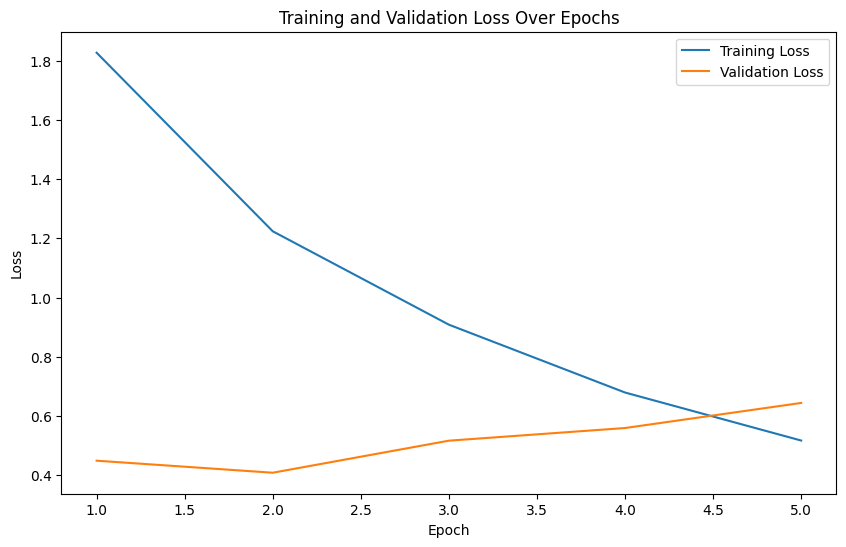

Tokenizer loaded from /kaggle/working/tokenizer_xlm_roberta


/tmp/ipykernel_23/2276075236.py:700: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_load_path, map_location=device))


Model loaded from /kaggle/working/multi_task_xlm_roberta.pth
Classification Report for Hate:
              precision    recall  f1-score   support

         NOT       0.83      0.86      0.84       312
        HATE       0.85      0.83      0.84       313

    accuracy                           0.84       625
   macro avg       0.84      0.84      0.84       625
weighted avg       0.84      0.84      0.84       625

--------------------------------------------------
Classification Report for Offensive:
              precision    recall  f1-score   support

         NOT       0.87      0.86      0.86       313
        OFFN       0.86      0.87      0.86       312

    accuracy                           0.86       625
   macro avg       0.86      0.86      0.86       625
weighted avg       0.86      0.86      0.86       625

--------------------------------------------------
Classification Report for Sentiment:
              precision    recall  f1-score   support

    NEGATIVE       0.8

In [1]:
import random
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import XLMRobertaTokenizer, XLMRobertaModel, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import f1_score, precision_recall_fscore_support, classification_report
from sklearn.utils.class_weight import compute_class_weight
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, auc

def set_seed(seed=42):
    """
    Sets fixed random seeds for reproducibility.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # For deterministic behavior (may slow down training)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

mr_sent_train = pd.read_csv('/kaggle/input/marathi/tweets-train.csv')
mr_sent_test = pd.read_csv('/kaggle/input/marathi/tweets-test.csv')
mr_sent_valid = pd.read_csv('/kaggle/input/marathi/tweets-valid.csv')

# Combine Sentiment Datasets
dataset2 = pd.concat([mr_sent_train, mr_sent_valid, mr_sent_test], axis=0, ignore_index=True)
dataset2.rename(columns={'tweet': 'text'}, inplace=True)
print("Sentiment Dataset:")
print(dataset2.head())

# Load Hate Speech Datasets
mr_maha_hate_train = pd.read_excel('/kaggle/input/marathi/hate_train.xlsx')
mr_maha_hate_test = pd.read_excel('/kaggle/input/marathi/hate_test.xlsx')
mr_maha_hate_val = pd.read_excel('/kaggle/input/marathi/hate_valid.xlsx')

# Combine Hate Speech Datasets
dataset1 = pd.concat([mr_maha_hate_train, mr_maha_hate_val, mr_maha_hate_test], axis=0, ignore_index=True)
print("\nHate Speech Dataset:")
print(dataset1.head())

# Label Distribution in Hate Speech Dataset
print("\nHate Speech Label Distribution:")
print(dataset1['label'].value_counts())

# Label Distribution in Sentiment Dataset
print("\nSentiment Label Distribution:")
print(dataset2['label'].value_counts())

def clean_text(text):
    """
    Cleans the input text by removing URLs, mentions, hashtags, special characters, and extra whitespaces.
    """
    # Lowercase the text
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove user @ references and '#' from hashtags
    text = re.sub(r'\@\w+|\#','', text)

    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Apply cleaning to Hate Speech Dataset
dataset1['clean_text'] = dataset1['text'].apply(clean_text)

# Apply cleaning to Sentiment Dataset
dataset2['clean_text'] = dataset2['text'].apply(clean_text)

hate = dataset1[dataset1['label'] == 'HATE']
offensive = dataset1[dataset1['label'] == 'OFFN']
not_label = dataset1[dataset1['label'] == 'NOT']

# Determine the minimum number of samples among the classes
min_samples = min(len(hate), len(offensive), len(not_label)//2)

# Combine to form a balanced dataset
hate_dataset = pd.concat([hate[:min_samples], not_label[:min_samples]], axis=0).reset_index(drop=True)
offensive_dataset = pd.concat([offensive[:min_samples], not_label[min_samples:2*min_samples]], axis=0).reset_index(drop=True)

print("\nBalanced Hate Speech Dataset Label Distribution:")
print(hate_dataset['label'].value_counts())
print(offensive_dataset['label'].value_counts())

tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')
MAX_LEN = 128

# ----------------------------
# 5. Define Dataset Class
# ----------------------------
class MultiTaskHateDataset(Dataset):
    def __init__(self, hate_data, sentiment_data, offensive_data, tokenizer, max_len):
        """
        Initializes the dataset with hate speech, offensive language, and sentiment data.

        Parameters:
        - hate_data: DataFrame containing hate speech and 'NOT' labels.
        - sentiment_data: DataFrame containing sentiment labels.
        - offensive_data: DataFrame containing offensive and 'NOT' labels.
        - tokenizer: Tokenizer to encode the text.
        - max_len: Maximum length for tokenization.
        """
        self.hate_data = hate_data
        self.sentiment_data = sentiment_data
        self.offensive_data = offensive_data
        self.tokenizer = tokenizer
        self.max_len = max_len

        # Combine the datasets for multi-task learning
        self.data = self._create_multitask_data()

    def _create_multitask_data(self):
        """
        Combines hate, offensive, and sentiment datasets into a single DataFrame with task identifiers.
        """
        # Add a task identifier to each dataset
        ds_hate = self.hate_data.copy()
        ds_hate['task'] = 'hate'
        ds_hate = ds_hate.rename(columns={'label': 'task_label'})

        ds_offensive = self.offensive_data.copy()
        ds_offensive['task'] = 'offensive'
        ds_offensive = ds_offensive.rename(columns={'label': 'task_label'})

        ds_sentiment = self.sentiment_data.copy()
        ds_sentiment['task'] = 'sentiment'
        ds_sentiment = ds_sentiment.rename(columns={'label': 'task_label'})

        # Concatenate the datasets
        combined = pd.concat([ds_hate, ds_offensive, ds_sentiment], ignore_index=True)

        return combined

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        """
        Retrieves the tokenized inputs and labels for a given index.
        """
        row = self.data.iloc[idx]
        text = row['clean_text']
        task = row['task']
        label = row['task_label']

        # Tokenize the text
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        # Prepare the labels based on the task
        if task == 'hate':
            # Labels: 'HATE' -> 1, 'NOT' -> 0
            label_map = {'HATE': 1, 'NOT': 0}
            label = label_map.get(label, 0)  # Default to 'NOT' if not found

        elif task == 'offensive':
            # Labels: 'OFFN' -> 1, 'NOT' -> 0
            label_map = {'OFFN': 1, 'NOT': 0}
            label = label_map.get(label, 0)  # Default to 'NOT' if not found

        elif task == 'sentiment':
            # Labels: 'POSITIVE' -> 2, 'NEUTRAL' -> 1, 'NEGATIVE' -> 0
            label_map = {-1: 0, 0: 1, 1: 2}
            label = label_map.get(label, 1)  # Default to 'NEUTRAL' if not found

        else:
            label = -1  # Undefined task

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'task': task,
            'labels': torch.tensor(label, dtype=torch.long)
        }

multitask_dataset = MultiTaskHateDataset(
    hate_data=hate_dataset,          # Balanced Hate Speech Dataset
    sentiment_data=pd.concat([dataset2[dataset2['label']==-1][:2500], dataset2[dataset2['label']==0][:2500], dataset2[dataset2['label']==1][:2500]]),         # Sentiment Dataset
    offensive_data=offensive_dataset, # Balanced Offensive Dataset
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

# Split the combined data into training and testing sets
train_size = 0.9
# Stratify by both 'task' and 'task_label' to maintain label distribution across splits
train_data, test_data = train_test_split(
    multitask_dataset.data,
    test_size=1 - train_size,
    random_state=42,
    stratify=multitask_dataset.data[['task', 'task_label']]
)

# Create training and testing datasets
train_dataset = MultiTaskHateDataset(
    hate_data=train_data[train_data['task'] == 'hate'],
    sentiment_data=train_data[train_data['task'] == 'sentiment'],
    offensive_data=train_data[train_data['task'] == 'offensive'],
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

test_dataset = MultiTaskHateDataset(
    hate_data=test_data[test_data['task'] == 'hate'],
    sentiment_data=test_data[test_data['task'] == 'sentiment'],
    offensive_data=test_data[test_data['task'] == 'offensive'],
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

# Verify Label Distribution in Splits
print("\nTraining Set Label Distribution:")
print(train_dataset.data['task'].value_counts())

print("\nValidation Set Label Distribution:")
print(test_dataset.data['task'].value_counts())

BATCH_SIZE = 16

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

class MultiTaskXLMR(nn.Module):
    def __init__(self, model_name, num_labels_hate, num_labels_offensive, num_labels_sentiment):
        """
        Initializes the multi-task model with separate classification heads.

        Parameters:
        - model_name: Pre-trained model name (e.g., 'xlm-roberta-base').
        - num_labels_hate: Number of labels for hate task.
        - num_labels_offensive: Number of labels for offensive task.
        - num_labels_sentiment: Number of labels for sentiment task.
        """
        super(MultiTaskXLMR, self).__init__()
        self.encoder = XLMRobertaModel.from_pretrained(model_name)
        hidden_size = self.encoder.config.hidden_size

        # Classification head for hate task
        self.classifier_hate = nn.Linear(hidden_size, num_labels_hate)

        # Classification head for offensive task
        self.classifier_offensive = nn.Linear(hidden_size, num_labels_offensive)

        # Classification head for sentiment task
        self.classifier_sentiment = nn.Linear(hidden_size, num_labels_sentiment)

        # Dropout layer
        self.dropout = nn.Dropout(0.3)

    def forward(self, input_ids, attention_mask, task):
        """
        Forward pass for the model.

        Parameters:
        - input_ids: Tokenized input IDs.
        - attention_mask: Attention masks.
        - task: Task identifier ('hate', 'offensive', 'sentiment').

        Returns:
        - logits: Output logits for the specified task.
        """
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]  # [CLS] token
        cls_output = self.dropout(cls_output)

        if task == 'hate':
            logits = self.classifier_hate(cls_output)
        elif task == 'offensive':
            logits = self.classifier_offensive(cls_output)
        elif task == 'sentiment':
            logits = self.classifier_sentiment(cls_output)
        else:
            raise ValueError(f"Unknown task: {task}")

        return logits

num_labels_hate = 2          # 'HATE' -> 1, 'NOT' -> 0
num_labels_offensive = 2     # 'OFFN' -> 1, 'NOT' -> 0
num_labels_sentiment = 3     # 'NEGATIVE' -> 0, 'NEUTRAL' -> 1, 'POSITIVE' -> 2

# Initialize the multi-task model
model = MultiTaskXLMR(
    model_name='xlm-roberta-base',
    num_labels_hate=num_labels_hate,
    num_labels_offensive=num_labels_offensive,
    num_labels_sentiment=num_labels_sentiment
)

# ----------------------------
# 9. Move Model to Device
# ----------------------------
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)

# Compute class weights for hate task
labels_hate = train_dataset.hate_data['task_label'].map({'HATE': 1, 'NOT': 0}).values
class_weights_hate = compute_class_weight(class_weight='balanced', classes=np.unique(labels_hate), y=labels_hate)
class_weights_hate = torch.tensor(class_weights_hate, dtype=torch.float).to(device)

# Compute class weights for offensive task
labels_offensive = train_dataset.offensive_data['task_label'].map({'OFFN': 1, 'NOT': 0}).values
class_weights_offensive = compute_class_weight(class_weight='balanced', classes=np.unique(labels_offensive), y=labels_offensive)
class_weights_offensive = torch.tensor(class_weights_offensive, dtype=torch.float).to(device)

# Compute class weights for sentiment task
labels_sentiment = train_dataset.sentiment_data['task_label'].map({-1: 0, 0: 1, 1: 2}).values
class_weights_sentiment = compute_class_weight(class_weight='balanced', classes=np.unique(labels_sentiment), y=labels_sentiment)
class_weights_sentiment = torch.tensor(class_weights_sentiment, dtype=torch.float).to(device)

criterion_hate = nn.CrossEntropyLoss(weight=class_weights_hate)
criterion_offensive = nn.CrossEntropyLoss(weight=class_weights_offensive)
criterion_sentiment = nn.CrossEntropyLoss(weight=class_weights_sentiment)

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

# Total number of training steps
EPOCHS = 5
total_steps = len(train_loader) * EPOCHS

# Define scheduler with warm-up steps
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),  # 10% of total steps for warm-up
    num_training_steps=total_steps
)

def train_epoch_multitask(
    model,
    data_loader,
    optimizer,
    device,
    scheduler,
    criterion_hate,
    criterion_offensive,
    criterion_sentiment
):
    """
    Trains the model for one epoch on the multi-task dataset.

    Parameters:
    - model: The multi-task model.
    - data_loader: DataLoader for training data.
    - optimizer: Optimizer.
    - device: Device to run the model on.
    - scheduler: Learning rate scheduler.
    - criterion_hate: Loss function for hate task.
    - criterion_offensive: Loss function for offensive task.
    - criterion_sentiment: Loss function for sentiment task.

    Returns:
    - Average training loss for the epoch.
    """
    model.train()
    losses = []

    for batch_idx, batch in enumerate(data_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        tasks = batch['task']
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        # Identify unique tasks in the current batch
        unique_tasks = set(tasks)

        # Initialize total loss for the batch
        total_loss = 0

        for task in unique_tasks:
            # Get indices for the current task
            indices = [i for i, t in enumerate(tasks) if t == task]
            if not indices:
                continue  # Skip if no instances for the task

            # Select inputs and labels for the current task
            task_input_ids = input_ids[indices]
            task_attention_mask = attention_mask[indices]
            task_labels = labels[indices]

            # Forward pass
            logits = model(input_ids=task_input_ids, attention_mask=task_attention_mask, task=task)

            # Compute loss based on the task
            if task == 'hate':
                loss = criterion_hate(logits, task_labels)
            elif task == 'offensive':
                loss = criterion_offensive(logits, task_labels)
            elif task == 'sentiment':
                loss = criterion_sentiment(logits, task_labels)
            else:
                raise ValueError(f"Unknown task: {task}")

            # Accumulate loss
            total_loss += loss

        # Backward pass and optimization
        total_loss.backward()

        # Gradient Clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        scheduler.step()

        # Record loss
        losses.append(total_loss.item())

        # Debugging: Print loss every 100 batches
        if (batch_idx + 1) % 100 == 0:
            print(f'Batch {batch_idx + 1}/{len(data_loader)} - Loss: {total_loss.item():.4f}')

        # Optional: Check gradient flow
        # Uncomment the following lines to verify gradients
        # for name, param in model.named_parameters():
        #     if param.requires_grad and param.grad is not None:
        #         print(f"Gradients for {name}: {param.grad.abs().mean()}")

    return np.mean(losses)

def eval_model_multitask(
    model,
    data_loader,
    criterion_hate,
    criterion_offensive,
    criterion_sentiment,
    device
):
    """
    Evaluates the model on the validation/test dataset.

    Parameters:
    - model: The multi-task model.
    - data_loader: DataLoader for validation/test data.
    - criterion_hate: Loss function for hate task.
    - criterion_offensive: Loss function for offensive task.
    - criterion_sentiment: Loss function for sentiment task.
    - device: Device to run the model on.

    Returns:
    - Average loss, precision, recall, and F1 score for each task.
    """
    model.eval()
    losses = []
    all_labels = {'hate': [], 'offensive': [], 'sentiment': []}
    all_preds = {'hate': [], 'offensive': [], 'sentiment': []}

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            tasks = batch['task']
            labels = batch['labels'].to(device)

            # Identify unique tasks in the current batch
            unique_tasks = set(tasks)

            # Initialize total loss for the batch
            total_loss = 0

            for task in unique_tasks:
                # Get indices for the current task
                indices = [i for i, t in enumerate(tasks) if t == task]
                if not indices:
                    continue

                # Select inputs and labels for the current task
                task_input_ids = input_ids[indices]
                task_attention_mask = attention_mask[indices]
                task_labels = labels[indices]

                # Forward pass
                logits = model(input_ids=task_input_ids, attention_mask=task_attention_mask, task=task)

                # Compute loss based on the task
                if task == 'hate':
                    loss = criterion_hate(logits, task_labels)
                elif task == 'offensive':
                    loss = criterion_offensive(logits, task_labels)
                elif task == 'sentiment':
                    loss = criterion_sentiment(logits, task_labels)
                else:
                    raise ValueError(f"Unknown task: {task}")

                # Accumulate loss
                total_loss += loss

                # Predictions
                preds = torch.argmax(logits, dim=1)

                # Collect labels and predictions
                all_labels[task].extend(task_labels.cpu().numpy())
                all_preds[task].extend(preds.cpu().numpy())

            # Record loss
            losses.append(total_loss.item())

    # Calculate metrics for each task
    f1 = {}
    precision = {}
    recall = {}

    for task in all_labels:
        precision[task], recall[task], f1[task], _ = precision_recall_fscore_support(
            all_labels[task], all_preds[task], average='weighted', zero_division=0
        )

    avg_loss = np.mean(losses)

    return avg_loss, precision, recall, f1

def detailed_evaluation(model, data_loader, device):
    """
    Generates detailed classification reports for each task.

    Parameters:
    - model: The multi-task model.
    - data_loader: DataLoader for validation/test data.
    - device: Device to run the model on.
    """
    model.eval()
    all_labels = {'hate': [], 'offensive': [], 'sentiment': []}
    all_preds = {'hate': [], 'offensive': [], 'sentiment': []}

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            tasks = batch['task']
            labels = batch['labels'].to(device)

            # Identify unique tasks in the current batch
            unique_tasks = set(tasks)

            for task in unique_tasks:
                # Get indices for the current task
                indices = [i for i, t in enumerate(tasks) if t == task]
                if not indices:
                    continue

                # Select inputs and labels for the current task
                task_input_ids = input_ids[indices]
                task_attention_mask = attention_mask[indices]
                task_labels = labels[indices]

                # Forward pass
                logits = model(input_ids=task_input_ids, attention_mask=task_attention_mask, task=task)

                # Predictions
                preds = torch.argmax(logits, dim=1)

                # Collect labels and predictions
                all_labels[task].extend(task_labels.cpu().numpy())
                all_preds[task].extend(preds.cpu().numpy())

    # Generate classification reports
    for task in all_labels:
        print(f'Classification Report for {task.capitalize()}:')
        if task == 'hate':
            target_names = ['NOT', 'HATE']
        elif task == 'offensive':
            target_names = ['NOT', 'OFFN']
        elif task == 'sentiment':
            target_names = ['NEGATIVE', 'NEUTRAL', 'POSITIVE']  # {-1: 0, 0: 1, 1: 2}
        else:
            target_names = []
        print(classification_report(all_labels[task], all_preds[task], target_names=target_names, zero_division=0))
        print('-' * 50)

best_f1 = {'hate': 0, 'offensive': 0, 'sentiment': 0}
loss_history = {'train': [], 'val': []}  # To store loss values for plotting

# ----------------------------
# 16. Training Loop
# ----------------------------
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    # Training Phase
    train_loss = train_epoch_multitask(
        model=model,
        data_loader=train_loader,
        optimizer=optimizer,
        device=device,
        scheduler=scheduler,
        criterion_hate=criterion_hate,
        criterion_offensive=criterion_offensive,
        criterion_sentiment=criterion_sentiment
    )

    print(f'Train loss: {train_loss:.4f}')
    loss_history['train'].append(train_loss)

    # Evaluation Phase
    val_loss, val_precision, val_recall, val_f1 = eval_model_multitask(
        model=model,
        data_loader=test_loader,
        criterion_hate=criterion_hate,
        criterion_offensive=criterion_offensive,
        criterion_sentiment=criterion_sentiment,
        device=device
    )

    print(f'Validation loss: {val_loss:.4f}')
    print(f'Validation Precision: Hate: {val_precision["hate"]:.4f}, Offensive: {val_precision["offensive"]:.4f}, Sentiment: {val_precision["sentiment"]:.4f}')
    print(f'Validation Recall: Hate: {val_recall["hate"]:.4f}, Offensive: {val_recall["offensive"]:.4f}, Sentiment: {val_recall["sentiment"]:.4f}')
    print(f'Validation F1 Score: Hate: {val_f1["hate"]:.4f}, Offensive: {val_f1["offensive"]:.4f}, Sentiment: {val_f1["sentiment"]:.4f}')
    print()

    loss_history['val'].append(val_loss)

    # Check and save the best model based on F1 score
    for task in best_f1:
        if val_f1[task] > best_f1[task]:
            best_f1[task] = val_f1[task]
            checkpoint_path = f'/kaggle/working/best_model_{task}.pth'
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Best model for task '{task}' saved to {checkpoint_path}")

# ----------------------------
# 17. Save the Final Model and Components
# ----------------------------

# Define the path where you want to save the model
model_save_path = '/kaggle/working/multi_task_xlm_roberta.pth'

# Save the model's state_dict
torch.save(model.state_dict(), model_save_path)
print(f"Model state_dict saved to {model_save_path}")

# Define the path to save the tokenizer
tokenizer_save_path = '/kaggle/working/tokenizer_xlm_roberta'

# Save the tokenizer
tokenizer.save_pretrained(tokenizer_save_path)
print(f"Tokenizer saved to {tokenizer_save_path}")

# Save the optimizer state
optimizer_save_path = '/kaggle/working/optimizer.pth'
torch.save(optimizer.state_dict(), optimizer_save_path)
print(f"Optimizer state_dict saved to {optimizer_save_path}")

# Save the scheduler state
scheduler_save_path = '/kaggle/working/scheduler.pth'
torch.save(scheduler.state_dict(), scheduler_save_path)
print(f"Scheduler state_dict saved to {scheduler_save_path}")

# 18. Plot Training and Validation Losses
# ----------------------------
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS + 1), loss_history['train'], label='Training Loss')
plt.plot(range(1, EPOCHS + 1), loss_history['val'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# ----------------------------
# 19. Load the Saved Model for Evaluation
# ----------------------------

# Define the path to save the tokenizer
tokenizer_load_path = '/kaggle/working/tokenizer_xlm_roberta'
# Load the tokenizer
tokenizer = XLMRobertaTokenizer.from_pretrained(tokenizer_load_path)
print(f"Tokenizer loaded from {tokenizer_load_path}")

# Load the saved state_dict
model_load_path = '/kaggle/working/multi_task_xlm_roberta.pth'
model.load_state_dict(torch.load(model_load_path, map_location=device))
model.to(device)
model.eval()
print(f"Model loaded from {model_load_path}")

# Generate detailed classification reports
detailed_evaluation(model, test_loader, device)

In [3]:
# Define the path to your Hindi TSV files
hindi_tsv_path1 = '/kaggle/input/hasoc2019/hasoc2019_hi_test_gold_2919.tsv'
hindi_tsv_path2 = '/kaggle/input/hasoc2019/hindi_dataset.tsv'

# Load the TSV files into pandas DataFrames
hindi_df1 = pd.read_csv(hindi_tsv_path1, sep='\t')  # Adjust 'sep' if different
hindi_df2 = pd.read_csv(hindi_tsv_path2, sep='\t')  # Adjust 'sep' if different

# Concatenate the two DataFrames
hindi_combined_df = pd.concat([hindi_df1, hindi_df2], axis=0, ignore_index=True)
hindi_combined_df['label'] = hindi_combined_df['task_1'].map({'NOT': 'NOT', 'HOF': 'HATE'})
print(f"Combined Hindi Dataset Shape: {hindi_combined_df.shape}")
hindi_combined_df['clean_text'] = hindi_combined_df['text'].apply(clean_text)

hindi_combined_df = hindi_combined_df[['text', 'label', 'clean_text']]


class InferenceDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        """
        Initializes the dataset for inference.

        Parameters:
        - dataframe: pandas DataFrame containing the data.
        - tokenizer: Tokenizer to encode the text.
        - max_len: Maximum length for tokenization.
        """
        self.texts = dataframe['clean_text'].tolist()
        self.labels = dataframe['label'].tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        """
        Retrieves the tokenized inputs for a given index.
        """
        text = self.texts[idx]
        label = self.labels[idx]

        # Tokenize the text
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'text': text,  # Optional: to keep track of the original text,
            'label': label
        }


# Define maximum sequence length (should match training)
MAX_LEN = 128

# Instantiate the Inference Dataset
inference_dataset = InferenceDataset(
    dataframe=hindi_combined_df,
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

# Create DataLoader
BATCH_SIZE = 16

inference_loader = DataLoader(
    inference_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

def predict_tasks(model, data_loader, device):
    """
    Runs inference on the data_loader and returns predictions for each task.

    Parameters:
    - model: The trained multi-task model.
    - data_loader: DataLoader for inference data.
    - device: Device to run the model on.

    Returns:
    - predictions: Dictionary containing predictions for each task.
    """
    model.eval()
    predictions = {'hate': [], 'offensive': [], 'sentiment': []}

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            # For each task, perform inference separately
            for task in ['hate', 'offensive', 'sentiment']:
                logits = model(input_ids=input_ids, attention_mask=attention_mask, task=task)
                preds = torch.argmax(logits, dim=1).cpu().numpy()
                predictions[task].extend(preds)

    return predictions

# Run inference
predictions = predict_tasks(model, inference_loader, device)

# Display sample predictions
print("\nSample Predictions:")
for i in range(5):
    print(f"Text: {hindi_combined_df['text'].iloc[i]}")
    print(f"True Label: {hindi_combined_df['label'].iloc[i]}")
    print(f"Hate Prediction: {'HATE' if predictions['hate'][i] == 1 else 'NOT'}")
    print(f"Offensive Prediction: {'OFFN' if predictions['offensive'][i] == 1 else 'NOT'}")
    sentiment_map = {0: 'NEGATIVE', 1: 'NEUTRAL', 2: 'POSITIVE'}
    print(f"Sentiment Prediction: {sentiment_map.get(predictions['sentiment'][i], 'UNKNOWN')}")
    print("-" * 50)

# Map hate predictions to labels
hate_map = {0: 'NOT', 1: 'HATE'}
hindi_combined_df['hate_prediction'] = predictions['hate']
hindi_combined_df['hate_prediction'] = hindi_combined_df['hate_prediction'].map(hate_map)

# Classification Report for Hate Task
print("Classification Report for Hate Task:")
print(classification_report(hindi_combined_df['label'], hindi_combined_df['hate_prediction'], zero_division=0))

Combined Hindi Dataset Shape: (5983, 6)

Sample Predictions:
Text: वक्त, इन्सान और इंग्लैंड का मौसम आपको कभी भी धोखा दे सकता है।  #IndiaVsPakistan
True Label: NOT
Hate Prediction: NOT
Offensive Prediction: NOT
Sentiment Prediction: NEGATIVE
--------------------------------------------------
Text: #कांग्रेस के इस #कमीने की #करतूत को देखिए देश की रक्षा करते #शहीद हुए मां भारती के #सपूतों का ख्याल भी नहीं रखा #दुश्मन से गले मिल गये  #शर्मनाक. ये पूरे शहीद का अपमान किया है। मैं बहुत कद्र करते थे सिंधु को लेकिन ये तो नकारा है।
True Label: HATE
Hate Prediction: NOT
Offensive Prediction: NOT
Sentiment Prediction: NEGATIVE
--------------------------------------------------
Text: पाकिस्तान को फेकना था फेका गया। जो हार कर भी दुश्मन को हरा दे उसी को हमने नाम दिया। @BCCI  ये तुम्हारे समझ के बाहर हैं तुम बॉलीवुड में रंडी रोओ इधर मत घुसो।
True Label: HATE
Hate Prediction: HATE
Offensive Prediction: OFFN
Sentiment Prediction: NEGATIVE
--------------------------------------------------
Text: जो शब्द त

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/multi_task_xlm_roberta.pth (deflated 30%)
  adding: kaggle/working/best_model_hate.pth (deflated 30%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)
  adding: kaggle/working/tokenizer_xlm_roberta/ (stored 0%)
  adding: kaggle/working/tokenizer_xlm_roberta/special_tokens_map.json (deflated 52%)
  adding: kaggle/working/tokenizer_xlm_roberta/tokenizer_config.json (deflated 76%)
  adding: kaggle/working/tokenizer_xlm_roberta/sentencepiece.bpe.model (deflated 49%)
  adding: kaggle/working/best_model_offensive.pth (deflated 30%)
  adding: kaggle/working/best_model_sentiment.pth (deflated 30%)
  adding: kaggle/working/optimizer.pth (deflated 68%)
  adding: kaggle/working/scheduler.pth (deflated 54%)


/kaggle/working/marathi_final.zip